# Adaptive PDE discretizations on Cartesian grids
## Volume : Algorithmic tools
## Part : Domain representation
## Chapter : Finite differences, interpolation

This notebook presents the basic types of finite differences and interpolation methods that can be considered on a cartesian grid. The tools are presented in two dimensions, but apply in arbitrary dimension. They also apply in the context of:
* non-square domains, [example](SubsetRd.ipynb)
* point dependent offsets, [example](../Notebooks_NonDiv/LinearMonotoneSchemes2D.ipynb)
* vector valued functions.

[**Summary**](Summary.ipynb) of volume Algorithmic tools, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Degenerate elliptic finite differences](#1.-Degenerate-elliptic-finite-differences)
    * [1.1 Testing data](#1.1-Testing-data)
    * [1.2 Upwind finite difference](#1.2-Upwind-finite-difference)
    * [1.3 Second order finite difference](#1.3-Second-order-finite-difference)
    * [1.4 Centered finite difference](#1.4-Centered-finite-difference)
  * [2. Higher order finite differences](#2.-Higher-order-finite-differences)
    * [2.1 Upwind finite difference](#2.1-Upwind-finite-difference)
    * [2.2 Second order finite difference](#2.2-Second-order-finite-difference)
    * [2.3 Centered finite difference](#2.3-Centered-finite-difference)
  * [3. Composite finite differences](#3.-Composite-finite-differences)
    * [3.1 Gradient](#3.1-Gradient)
    * [3.2 Hessian](#3.2-Hessian)
  * [4. Interpolation](#4.-Interpolation)
    * [4.1 Linear splines](#4.1-Linear-splines)
    * [4.2 Quadratic splines](#4.2-Quadratic-splines)
    * [4.3 Cubic splines](#4.3-Cubic-splines)
    * [4.4 Vector data](#4.4-Vector-data)
    * [4.5 scipy ndimage map_coordinates](#4.5-scipy-ndimage-map_coordinates)
  * [5. Functions associated with an AD variable](#5.-Functions-associated-with-an-AD-variable)
    * [5.1 Taylor expansions](#5.1-Taylor-expansions)
    * [5.2 Sparse differentiation](#5.2-Sparse-differentiation)



**Acknowledgement.** Some of the experiments presented in these notebooks are part of 
ongoing research with Ludovic Métivier and Da Chen.

Copyright Jean-Marie Mirebeau, Centre Borelli, ENS Paris-Saclay, CNRS, University Paris-Saclay

## 0. Import the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow imports from parent directory
#from Miscellaneous import TocTools; print(TocTools.displayTOC('FiniteDifferences','Algo'))

In [2]:
from agd import FiniteDifferences as fd
from agd import AutomaticDifferentiation as ad
from agd import Interpolation
from agd import LinearParallel as lp
norm_infinity = ad.Optimization.norm_infinity

In [3]:
import numpy as np
from matplotlib import pyplot as plt

## 1. Degenerate elliptic finite differences

The finite difference presented in this section are a typical ingredient of monotone numerical schemes, see the corresponding [volume](../Notebooks_NonDiv/Summary.ipynb). 

### 1.1 Testing data

In order to test the finite difference and interpolation methods, we need some polynomial functions.

In [4]:
def u1(X): return X[0]+2*X[1]
def u2(X): return X[0]**2+2*(2*X[0]*X[1])+3*X[1]**2
def u3(X): return X[0]**3+X[0]*X[1]**2

def u123(X): return ad.array( (u1(X),u2(X),u3(X)) )

We also need to choose a direction, with *integer coordinates*, for the finite differences.

In [5]:
e = (1,2)

Let us also define a domain, here a square.

In [6]:
aX,h = np.linspace(-1,1,retstep=True)
X=np.array(np.meshgrid(aX,aX,indexing='ij'))
shape = X.shape[1:]

def interior(shape,k):
    """Boolean array excluding k boundary layers"""
    interior = np.full(shape,True)
    for i in range(len(shape)): 
        interior[*(slice(None),)*i,:k]=False
        interior[*(slice(None),)*i,-k:]=False
    return interior
    
def close(u,v,k,ndim=2,**kwargs):
    """
    Wether u and v are close in the domain minus k boundary layers.
    - **kwargs : passed to np.allclose
    """
    dom = interior(u.shape[-ndim:],k)
#    print(norm_infinity(u[...,dom]-v[...,dom]),kwargs)
    return np.allclose(u[...,dom],v[...,dom],**kwargs)

In [7]:
interior((5,5),1)

array([[False, False, False, False, False],
       [False,  True,  True,  True, False],
       [False,  True,  True,  True, False],
       [False,  True,  True,  True, False],
       [False, False, False, False, False]])

The following variables are used for validation, by comparison with automatic differentiation.

In [8]:
X_ad = ad.Dense.identity(constant=X,shape_free=(2,))
X_ad2 = ad.Dense2.identity(constant=X,shape_free=(2,))

du1  = u1(X_ad).gradient()
du2  = u2(X_ad).gradient()
ddu2 = u2(X_ad2).hessian()
du3  = u3(X_ad).gradient()
ddu3 = u3(X_ad2).hessian()

_e = fd.as_field(e,shape)
du1_e  = lp.dot_VV(du1,_e)
du2_e  = lp.dot_VV(du2,_e)
ddu2_e = lp.dot_VAV(_e,ddu2,_e)
du3_e  = lp.dot_VV(du3,_e)
ddu3_e = lp.dot_VAV(_e,ddu3,_e)

### 1.2 Upwind finite difference
$$
    \frac{u(x+he)-u(x)} h = <\nabla u(x),e> + O(h).
$$

In [9]:
Du1_e = fd.DiffUpwind(u1(X),e,h)
assert close(Du1_e,du1_e,2)

### 1.3 Second order finite difference
$$
    \frac{u(x+he)-2u(x)+u(x-he)}{h^2} = <e,\nabla^2 u(x),e> + O(h^2).
$$

In [10]:
DDu2_e = fd.Diff2(u2(X),e,h)
assert close(DDu2_e,ddu2_e,2)

### 1.4 Centered finite difference

Centered finite differences *are not* degenerate elliptic, but they can be used within degenerate elliptic schemes if they are suitably compensated by second order finite differences.
$$
    \frac{u(x+h e)-u(x-h e)} {2 h} = <\nabla u(x),e> + O(h^2). 
$$

In [11]:
Du2_e = fd.DiffCentered(u2(X),e,h)
assert close(Du2_e,du2_e,2)

## 2. Higher order finite differences

High order finite differences are not degenerate elliptic. They may be used within filtered schemes, which combine a stable degenerate elliptic scheme with a higher order scheme.
By construction, they are exact on higher order polynomials.

### 2.1 Upwind finite difference
$$
    \frac{-u(x+2he)+4u(x+he)-3u(x)}{2h} = <\nabla u(x),e> + O(h^2)
$$

In [12]:
Du2_e = fd.DiffUpwind(u2(X),e,h,order=2)
assert close(Du2_e,du2_e,4)

$$
    \frac{2 u(x+3he)-9 u(x+2he)+18 u(x+he)-11 u(x)}{6h} = <\nabla u(x),e> + O(h^3)
$$

In [13]:
Du3_e = fd.DiffUpwind(u3(X),e,h,order=3)
assert close(Du3_e,du3_e,6)

### 2.2 Second order finite difference

In [14]:
DDu3_e = fd.Diff2(u3(X),e,h,order=4)
assert close(DDu3_e,ddu3_e,4)

### 2.3 Centered finite difference

In [15]:
Du3_e = fd.DiffCentered(u3(X),e,h,order=4)
assert close(Du3_e,du3_e,6)

## 3. Composite finite differences
The following finite differences can be used to estimate numerically the derivatives of a function, but they are rarely adequate for building numerical schemes. We denote by $e_i$ the $i$-th element of the canonical basis.

### 3.1 Gradient
$$
    \frac{u(x+h e_i)-u(x-he_i)}{2h} = \frac {\partial u} {\partial x_i} + O(h^2), \qquad 0 \leq i < d.
$$

In [16]:
Du2 = fd.DiffGradient(u2(X),gridScale=h)
assert close(Du2,du2,2)

In [17]:
Du2.shape

(2, 50, 50)

### 3.2 Hessian
$$
    \frac{u(x+h e_i)-2u(x)+u(x-he_i)}{h^2} = \frac {\partial^2 u} {\partial^2 x_i} + O(h^2),
$$
for all $0\leq i < d$, and 
$$
    \frac{u(x+h e_i+h e_j)+u(x-he_i-h e_j)-u(x+h e_i -h e_j) - u(x-h e_i+he_j)}{4h^2} = \frac {\partial^2 u} {\partial x_i \partial x_j} + O(h^2), 
$$
for all distinct $i,j$.

In [18]:
DDu2 = fd.DiffHessian(u2(X),gridScale=h)
assert close(DDu2,ddu2,2)

In [19]:
DDu2.shape

(2, 2, 50, 50)

In [20]:
DDu3 = fd.DiffHessian(u3(X),gridScale=h,order=4)
assert close(DDu3,ddu3,4)

## 4. Interpolation

The agd library contains a partial reimplementation of the `scipy.ndimage.map_coordinates` function, which allows AD types, both for the coordinates and the input values. This is another avenue for numerically differentiating a function defined on a grid.

**Boundary conditions.**
We only support reflected (default) and periodic boundary conditions (`grid-mirror`, `grid-wrap`). 
As a result, the spline interpolation methods *does not* exactly reproduce polynomials. In the tests below, we exclude some boundary layers, and choose a sufficiently high tolerance, to account for this non-exactness.

Exact reproduction of low degree polynomials could be achieved with the `not a knot` boundary conditions, but these are substantially more difficult to implement, and numerically coslty. 

Let us define a finer grid.

In [21]:
aX_ = np.linspace(-1,1,80)
X_=np.array(np.meshgrid(aX_,aX_,indexing='ij'))
shape_ = X_[0].shape

In [22]:
Interp = Interpolation.UniformGridInterpolation

### 4.1 Linear splines

(Piecewise) Linear splines are continuous, and reproduce linear functions.
They are second order consistent
$$
    U_1^h(x) = u(x)+O(h^2).
$$

In [23]:
U1 = Interp(X,u1(X),order=1)
assert np.allclose(U1(X_),u1(X_))

The spline can be differentiated, and yields the a first order consistent estimation of the gradient, *except possibly at boundary points*.
$$
    \nabla U_1^h(x) = \nabla u(x) + O(h)
$$

In [24]:
dU1 = U1(X_ad).gradient()
assert close(dU1,du1,1)

### 4.2 Quadratic splines

Quadratic splines are continuously differentiable, and reproduce quadratic functions.
We use a not-a-knot boundary condition : in one dimension, the second derivative is continuous accross the second node from the left.
$$
    U_2^h(x) = u(x)+O(h^3).
$$

In [25]:
U2 = Interp(X,u2(X),order=2)
assert close(U2(X_),u2(X_),k=10,atol=1e-6)

The spline can be differentiated, one time or two times, and yields a second order consistent estimate of the gradient, and a first order consistent estimate of the hessian, *except possibly at boundary points*.
$$
    \nabla U_2^h(x) = \nabla u(x) + O(h^2),
$$
$$
    \nabla^2 U_2^h(x) = \nabla^2 u(x) + O(h).
$$

In [26]:
dU2 = U2(X_ad).gradient()
assert close(dU2,du2,k=10,atol=1e-6)

In [27]:
ddU2 = U2(X_ad2).hessian()
assert close(ddU2,ddu2,k=10,atol=1e-6)

### 4.3 Cubic splines

Cubic splines are twice continuously differentiable, and reproduce cubic functions.
We use a not-a-knot boundary condition : in one dimension, the third derivative is continuous accross the second node from the left, and likewise from the right.
$$
    U_3^h(x) = u(x)+O(h^4).
$$

In [28]:
U3 = Interp(X,u3(X),order=3)
assert close(U3(X_),u3(X_),k=10,atol=1e-6)

The spline can be differentiated two times, and yields consistent estimates of the gradient and hessian, *except possibly at boundary points*.
$$
    \nabla U_3^h(x) = \nabla u(x) + O(h^3),
$$
$$
    \nabla^2 U_3^h(x) = \nabla^2 u(x) + O(h^2).
$$

In [29]:
dU3 = U3(X_ad).gradient()
assert close(dU3,du3,k=10,atol=1e-6)

In [30]:
ddU3 = U3(X_ad2).hessian()
assert close(ddU3,ddu3,k=12,atol=1e-6)

### 4.4 Vector data

In [31]:
U123 = Interp(X,u123(X),order=3)
assert close(U123(X_),u123(X_),k=12,atol=1e-6)

### 4.5 Comparison with scipy ndimage map_coordinates

As announced above, our spline interpolation function (partially) reproduces `scipy.ndimage.map_coordinate`, and extends it to AD types. We make this transparent by providing a map_coordinates function.

In [32]:
agd_map_coordinates = Interpolation.map_coordinates

We also provide a small wrapper over ndimage.map_coordinates, which allows AD types for the input values (not the coordinates), as well as the interpolation of tensor data.

In [33]:
ndimage_map_coordinates = Interpolation.ndimage_map_coordinates

The implementations works both on the cpu and gpu, select by commenting/uncommenting the cell below. In the latter case, `scipy.ndimage.map_coordinates` is replaced with `cupyx.scipy.ndimage.map_coordinates`.

In [34]:
caster = lambda x:x # CPU

In [35]:
#caster = ad.cupy_generic.cupy_set # GPU

In [36]:
np.random.seed(42)
for i,(order,dom_shape,x_shape,c_shape,size_ad,mode) in enumerate([
    # One dimensional tests
    (1,(5,),(8,),(2,3),1,'reflect'),
    (2,(6,),(4,),(3,),1,'reflect'),
    (3,(4,),(2,),tuple(),2,'grid-mirror'),
    (4,(10,),(3,),(1,),-1,'grid-wrap'),
    (5,(10,),(3,2),(1,),-1,'grid-wrap'),

    # Two dimensional tests
    (1,(4,5),(3,),tuple(),-1,'grid-wrap'),
    (2,(4,6),(3,4),(5,),2,'grid-wrap'),
    (3,(4,6),(3,4),(5,),2,'reflect'),
    (5,(4,3),(2,1),(2,1),1,'reflect'),

    # Three dimensional tests
    (1,(4,5,6),(2,5),(2,3),1,'reflect'),
    (3,(6,2,3),(1,4),tuple(),2,'grid-mirror'),
]):
    print(f"--- {order=}, {dom_shape=}, {x_shape=}, {c_shape=}, {size_ad=} ---")
    vals = np.random.rand(*c_shape,*dom_shape)
    if size_ad>0: vals=ad.Dense.denseAD(vals,np.random.rand(*vals.shape,size_ad))
    pos = np.random.rand(len(dom_shape),*x_shape)*3*np.max(dom_shape)
    vals,pos = map(caster,(vals,pos))
    impl = agd_map_coordinates(vals,pos,order=order,mode=mode)
    scpy = ndimage_map_coordinates(vals,pos,order=order,mode=mode) #scipy.ndimage
    print("Absolute error : ",norm_infinity(impl-scpy))
    assert np.allclose(impl,scpy,atol=1e-2)

    # Note : the accuracy of scipy.ndimage uses float32 internally, hence its rather low accuracy 
    pos = np.array(np.meshgrid(*[np.arange(s,dtype=np.float64) for s in dom_shape], indexing='ij'))
    pos = caster(pos)
    impl = agd_map_coordinates(vals,pos,order=order,mode=mode)
    scpy = ndimage_map_coordinates(vals,pos,order=order,mode=mode)
    print("Reproduction error. impl:",norm_infinity(ad.remove_ad(impl-vals))," scpy:",norm_infinity(ad.remove_ad(scpy-vals)))
    if ad.is_ad(impl) and impl.size_ad>0:
        print("Reproduction max error. impl:",norm_infinity((impl-vals).coef)," scpy:",norm_infinity((scpy-vals).coef))

--- order=1, dom_shape=(5,), x_shape=(8,), c_shape=(2, 3), size_ad=1 ---
Absolute error :  denseAD(0.0,[0.])
Reproduction error. impl: 0.0  scpy: 0.0
Reproduction max error. impl: 0.0  scpy: 0.0
--- order=2, dom_shape=(6,), x_shape=(4,), c_shape=(3,), size_ad=1 ---
Absolute error :  denseAD(7.083111874806036e-12,[4.10549372e-12])
Reproduction error. impl: 2.220446049250313e-16  scpy: 1.1591035076197187e-10
Reproduction max error. impl: 2.220446049250313e-16  scpy: 6.718436917907411e-11
--- order=3, dom_shape=(4,), x_shape=(2,), c_shape=(), size_ad=2 ---
Absolute error :  denseAD(1.4526723157715082e-09,[-2.47407976e-07 -4.96368829e-07])
Reproduction error. impl: 1.3877787807814457e-17  scpy: 2.307997604145129e-08
Reproduction max error. impl: 2.220446049250313e-16  scpy: 7.886280012692204e-06
--- order=4, dom_shape=(10,), x_shape=(3,), c_shape=(1,), size_ad=-1 ---
Absolute error :  5.551115123125783e-17
Reproduction error. impl: 3.3306690738754696e-16  scpy: 2.220446049250313e-16
--- or

## 5. Functions associated with an AD variable



### 5.1 Taylor expansions

The automatic differentiation classes store a Taylor expansion of the approximated function, which can be evaluated directly. The tangent, adjoint, and hessian operators may also be extracted.

In [37]:
x = np.array([0.2,0.5])
H = X-fd.as_field(x,shape)
x_ad  = ad.Dense.identity(constant=x)
x_ad2 = ad.Dense2.identity(constant=x)

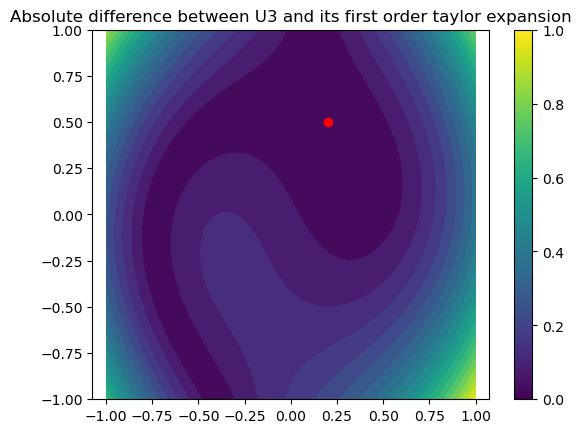

In [38]:
plt.title("Absolute difference between U3 and its first order taylor expansion")
plt.contourf(*X, np.abs(U3(x_ad).as_func(H) - U3(X)), levels=20);
plt.axis('equal'); plt.scatter(*x,color='red'); plt.colorbar();

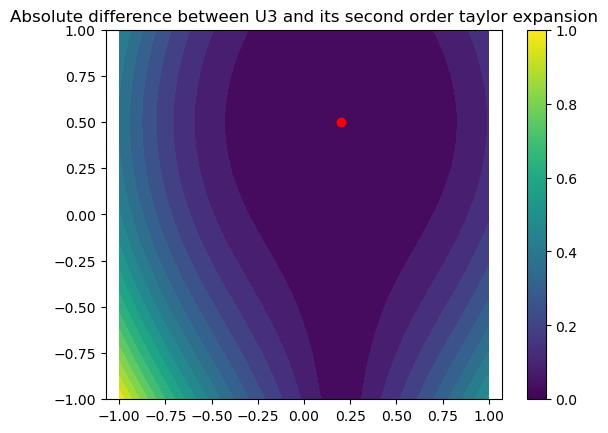

In [39]:
plt.title("Absolute difference between U3 and its second order taylor expansion")
plt.contourf(*X, np.abs(U3(x_ad2).as_func(H) - U3(X)), levels=20);
plt.axis('equal'); plt.scatter(*x,color='red'); plt.colorbar();

### 5.2 Sparse differentiation

When differentiating a high dimensional function, for instance in the context of a PDE discretization scheme, sparse automatic differentiation becomes for reasons of memory and computation cost. We check here the consistency of the related Taylor expansions. 

In [40]:
x_sp  = ad.Sparse.identity(constant=x)
x_sp2 = ad.Sparse2.identity(constant=x)

In [41]:
assert np.allclose(U3(x_sp ).as_func(H), U3(x_ad ).as_func(H))
assert np.allclose(U3(x_sp2).as_func(H), U3(x_ad2).as_func(H))

The sparse classes also provide tangent, adjoint, and hessian linear operators, stored as opaque sparse matrices.

In [42]:
tangent_op = U3(x_sp ).tangent_operator()
hessian_op = U3(x_sp2).hessian_operator()
H_ = H.reshape(2,-1) # Depth must be at most two

In [43]:
assert np.allclose(U3(x_sp ).as_func(H_), U3(x) + tangent_op*H_)
assert np.allclose(U3(x_sp2).as_func(H_), U3(x) + tangent_op*H_ + 0.5*lp.dot_VV(H_,hessian_op*H_))

Finally, we check the adjoint operator.

In [44]:
adjoint_op = U3(x_sp).adjoint_operator()

np.random.seed(42)
R_ = np.random.rand(1,H_.shape[1])

In [45]:
assert np.allclose(lp.dot_VV(R_,tangent_op*H_), lp.dot_VV(H_,adjoint_op*R_))